# Integration of Inhibitory neurons in Monkey AAI and Monkey V1

In [1]:
%pylab inline
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load data...

In [2]:
# load the Insular data...
insData = sc.read('../data_h5/Inhib_sorted.h5ad')

In [3]:
insData

AnnData object with n_obs × n_vars = 16364 × 19944
    obs: 'batch', 'doublet_score', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'sampleLayers', 'cluster_labels', 'Sex', 'mainMarker'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sex_colors', 'batch_colors', 'cluster_labels_colors', 'cluster_names', 'hvg', 'leiden', 'leiden_colors', 'mainMarker_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sampleLayers_colors', 'tsne', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_tsne', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'

In [4]:
ins_adata=sc.AnnData(insData.layers['RawCounts'],dict(obs_names=insData.obs_names),dict(var_names=insData.var_names))
ins_adata.obs['batch'] = insData.obs['batch'].astype('str')
ins_adata.obs['brainArea'] = 'Ins'
ins_adata.obs['species'] = 'monkey_Ins'
ins_adata.obs['cellTypeID'] = insData.obs['leiden']
ins_adata.obs['cellTypeLabel'] = insData.obs['cluster_labels']
ins_adata.obs['Sex'] = insData.obs['Sex']
ins_adata.obs['pct_counts_mt'] = insData.obs['pct_counts_mt']

del(insData)

In [5]:
# load the human counts data...
adata_v1 = sc.read('../data_h5/FM27_cell_133454_wk_1_backup.h5')

In [6]:
adata_v1

AnnData object with n_obs × n_vars = 133454 × 18297
    obs: 'Layer', 'MonkeyID', 'age', 'batch', 'cell_label', 'cell_label_old', 'class', 'louvain', 'marker1', 'marker2', 'n_counts', 'n_genes', 'name', 'percent_mito', 'subclass', 'cell_label_reorder', 'class_new', 'predict_type', 'class_show', 'cell_label1', 'cell_label_20210903', 'sex', 'subclass_1', 'cell_label_dendro', 'subclass_2'
    var: 'ENS', 'x', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Layer_colors', 'MonkeyID_colors', 'age_colors', 'cell_label1_colors', 'cell_label_colors', 'cell_label_colors_old', 'cell_label_colors_purpleNXPH4', 'cell_label_dendro_colors', 'cell_label_old_colors', 'cell_label_reorder_colors', 'class_colors', 'class_show_colors', 'dendrogram_cell_label_dendro', 'marker1_colors', 'marker2_colors', 'sex_colors', 'subclass_1_colors', 'subclass_2_colors', 'subclass_colors', 'sublcass_1_colors'
    obsm: 'X_harmonypca', 'X_neuron_tsne', 'X_pca', 'X_tsne',

In [7]:
# select the inhibitory neurons
adata_v1 = adata_v1[adata_v1.obs['batch'].isin(['1'])]

# create new scanpy object.
v1_adata=sc.AnnData(adata_v1.layers['counts'],dict(obs_names=adata_v1.obs_names),dict(var_names=adata_v1.var_names))
v1_adata.obs['species'] = 'monkey_V1'

v1_adata.obs['batch'] = adata_v1.obs['name']
v1_adata.obs['brainArea'] = 'V1'
v1_adata.obs['pct_counts_mt'] = adata_v1.obs['percent_mito']

sex_str = adata_v1.obs['sex'].astype(str)
sex_str[ adata_v1.obs['sex']=='M'] = 'Male'
sex_str[  adata_v1.obs['sex']=='F' ] = 'Female'
v1_adata.obs['Sex'] = adata_v1.obs['sex']

v1_adata.obs['cell_label1'] = adata_v1.obs['cell_label1']
v1_adata.obs['subclass_1'] = adata_v1.obs['subclass_1']
v1_adata.obs['subclass_2'] = adata_v1.obs['subclass_2']
v1_adata.uns['subclass_1_colors'] = adata_v1.uns['subclass_1_colors']
v1_adata.uns['cell_label1_colors'] = adata_v1.uns['cell_label1_colors']

del(adata_v1)

In [8]:
ins_adata

AnnData object with n_obs × n_vars = 16364 × 19944
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellTypeLabel', 'Sex', 'pct_counts_mt'

In [9]:
ins_adata.obs['batch_ori']=ins_adata.obs['batch']
v1_adata.obs['batch_ori']=v1_adata.obs['batch']

# integrate the datasets and compare the clusters...

In [10]:
adata = ins_adata.concatenate(v1_adata,index_unique = None)

In [11]:
adata

AnnData object with n_obs × n_vars = 28461 × 18268
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellTypeLabel', 'Sex', 'pct_counts_mt', 'batch_ori', 'cell_label1', 'subclass_1', 'subclass_2'

In [12]:
adata.var['mt'] = adata.var_names.isin(["ND1","ND2","COX1","COX2","COX3","ATP6","ATP8","ND3","ND4","ND5","ND6","ND4L","CYTB"])

In [13]:
adata.write('./data_tem/tem_integrated_Inh_ins_vs_v1_1.h5ad',compression='gzip')

In [14]:
# adata = sc.read('./data_tem/tem_integrated_Inh_ins_vs_v1_1.h5ad')

In [15]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata,batch_key="batch",flavor="seurat",n_top_genes=500,
    subset=True, min_mean=0.015, max_mean=10, min_disp=0.05 )
adata = adata[:, adata.var.highly_variable]

In [16]:
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

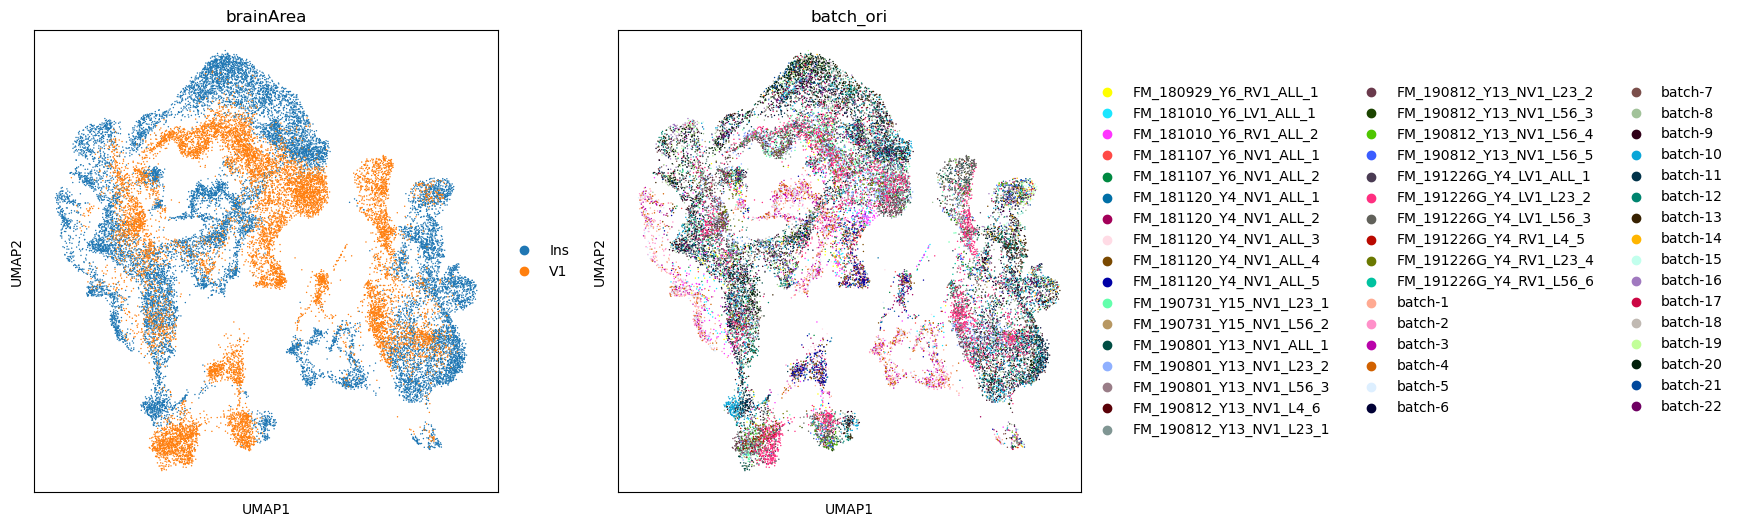

In [17]:
figsize(6,6)
sc.pl.umap(adata,color=['brainArea','batch_ori'])

In [18]:
adata.write('./data_tem/tem_integrated_Inh_ins_vs_v1_2.h5ad',compression='gzip')

## Integrate with harmoney

In [19]:
# adata = sc.read('./data_tem/tem_integrated_Inh_ins_vs_v1_2.h5ad')

In [20]:
import harmonypy as hm
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, ['batch_ori'],theta=8)
adata.obsm['X_harmonypca'] = ho.Z_corr.T
sc.pp.neighbors(adata, use_rep='X_harmonypca')
adata.obsm['X_umapraw'] = adata.obsm['X_umap']
sc.tl.umap(adata)
adata.obsm['X_umapharmony'] = adata.obsm['X_umap']

2025-03-01 12:01:19,451 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-01 12:01:29,207 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-01 12:01:29,326 - harmonypy - INFO - Iteration 1 of 10
2025-03-01 12:01:39,196 - harmonypy - INFO - Iteration 2 of 10
2025-03-01 12:01:49,226 - harmonypy - INFO - Iteration 3 of 10
2025-03-01 12:01:55,239 - harmonypy - INFO - Iteration 4 of 10
2025-03-01 12:02:05,458 - harmonypy - INFO - Iteration 5 of 10
2025-03-01 12:02:12,807 - harmonypy - INFO - Iteration 6 of 10
2025-03-01 12:02:18,470 - harmonypy - INFO - Iteration 7 of 10
2025-03-01 12:02:28,448 - harmonypy - INFO - Iteration 8 of 10
2025-03-01 12:02:39,281 - harmonypy - INFO - Iteration 9 of 10
2025-03-01 12:02:49,110 - harmonypy - INFO - Iteration 10 of 10
2025-03-01 12:02:55,030 - harmonypy - INFO - Converged after 10 iterations


In [21]:
adata

AnnData object with n_obs × n_vars = 28461 × 500
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellTypeLabel', 'Sex', 'pct_counts_mt', 'batch_ori', 'cell_label1', 'subclass_1', 'subclass_2', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'brainArea_colors', 'batch_ori_colors'
    obsm: 'X_pca', 'X_umap', 'X_harmonypca', 'X_umapraw', 'X_umapharmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

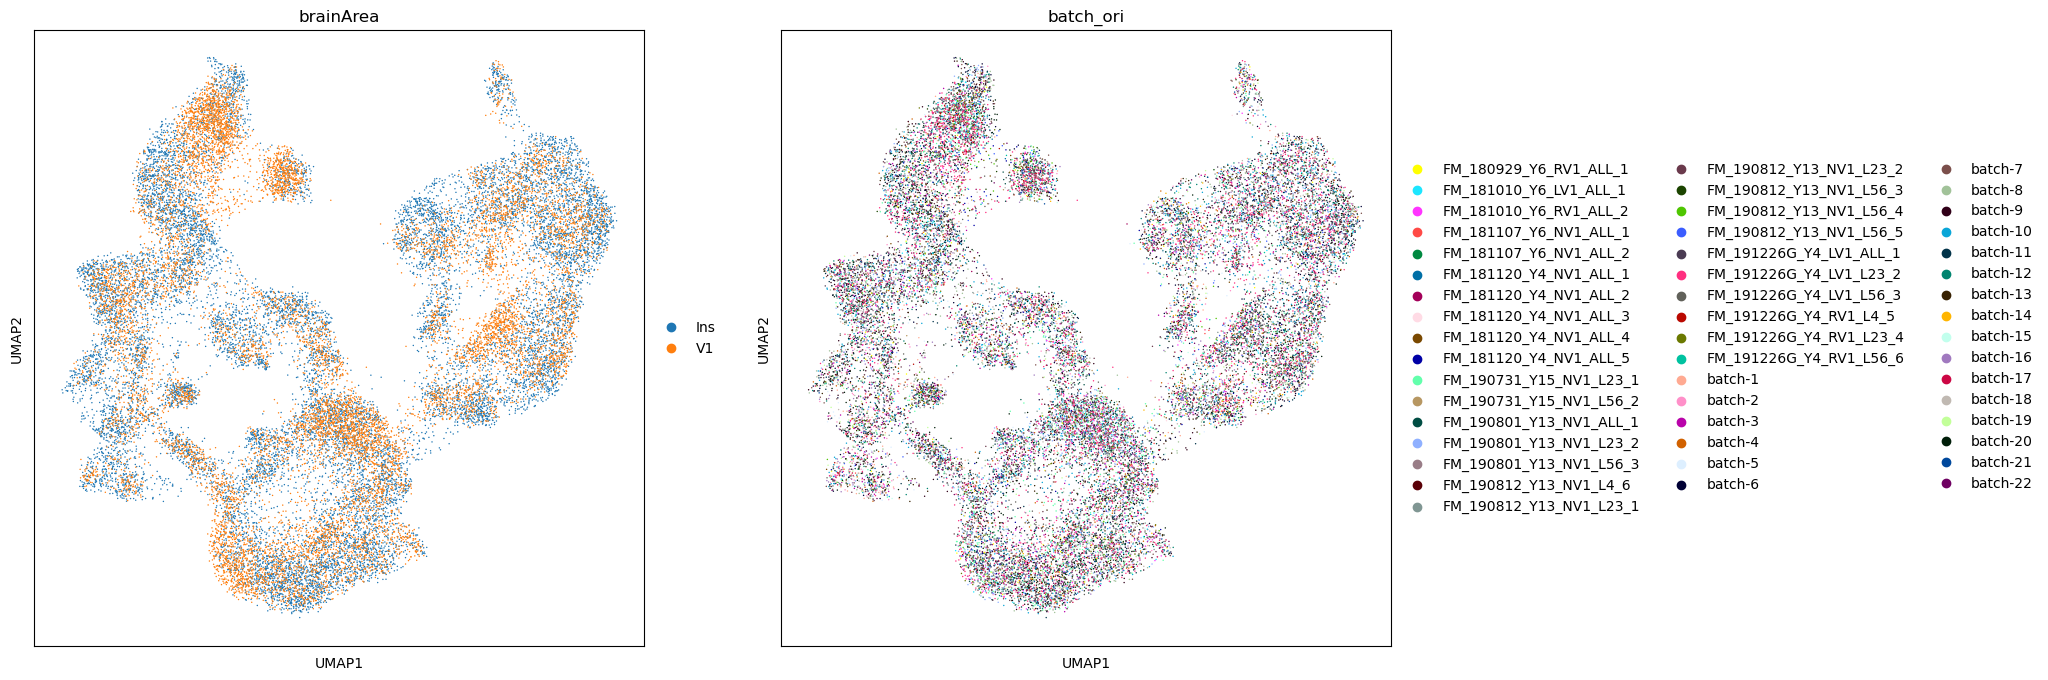

In [22]:
figsize(8,8)
sc.pl.umap(adata,color=['brainArea','batch_ori'])

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pylab inline
import sys
sys.path.append('../tools')
from two_species_heatmap import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [24]:
sc.pp.neighbors(adata,  metric='euclidean',use_rep = 'X_harmonypca' )
sc.tl.louvain(adata, resolution = 0.6, key_added = 'louvain')
adata.obs['louvain0_6'] = adata.obs['louvain']

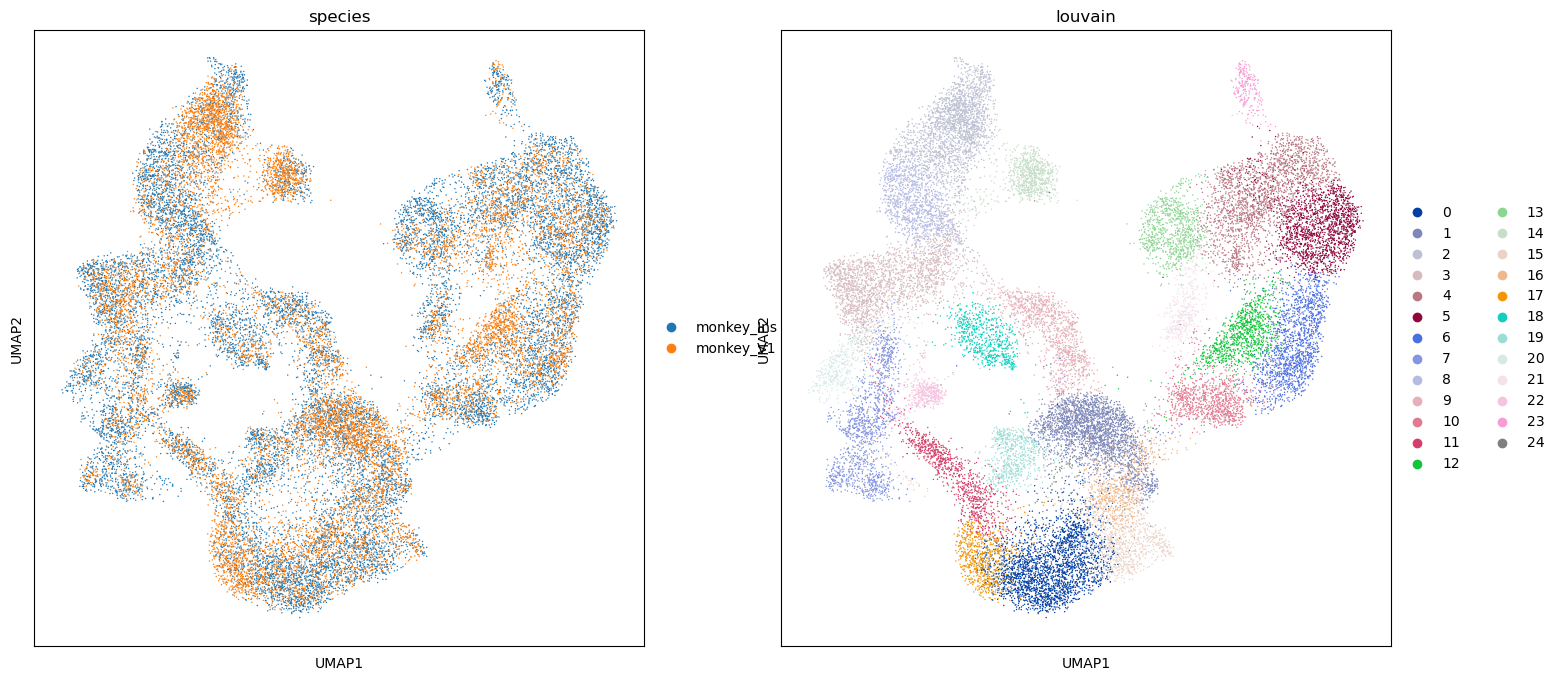

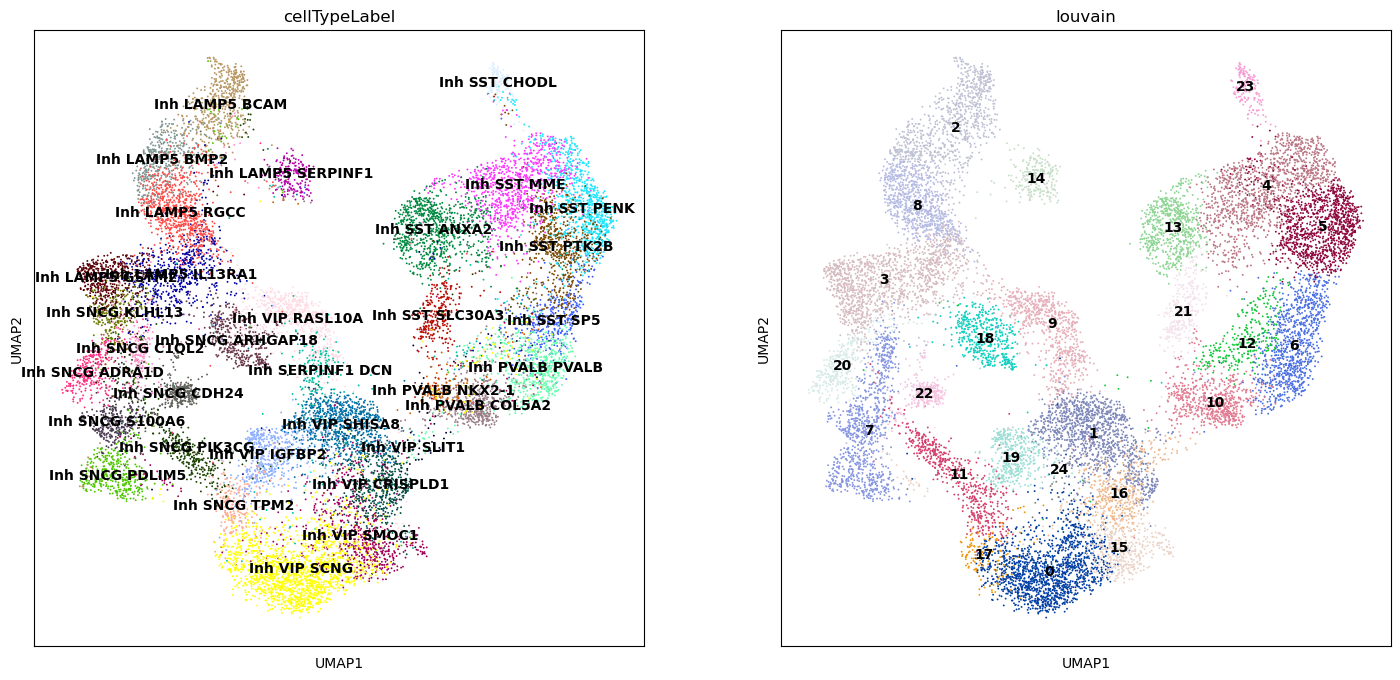

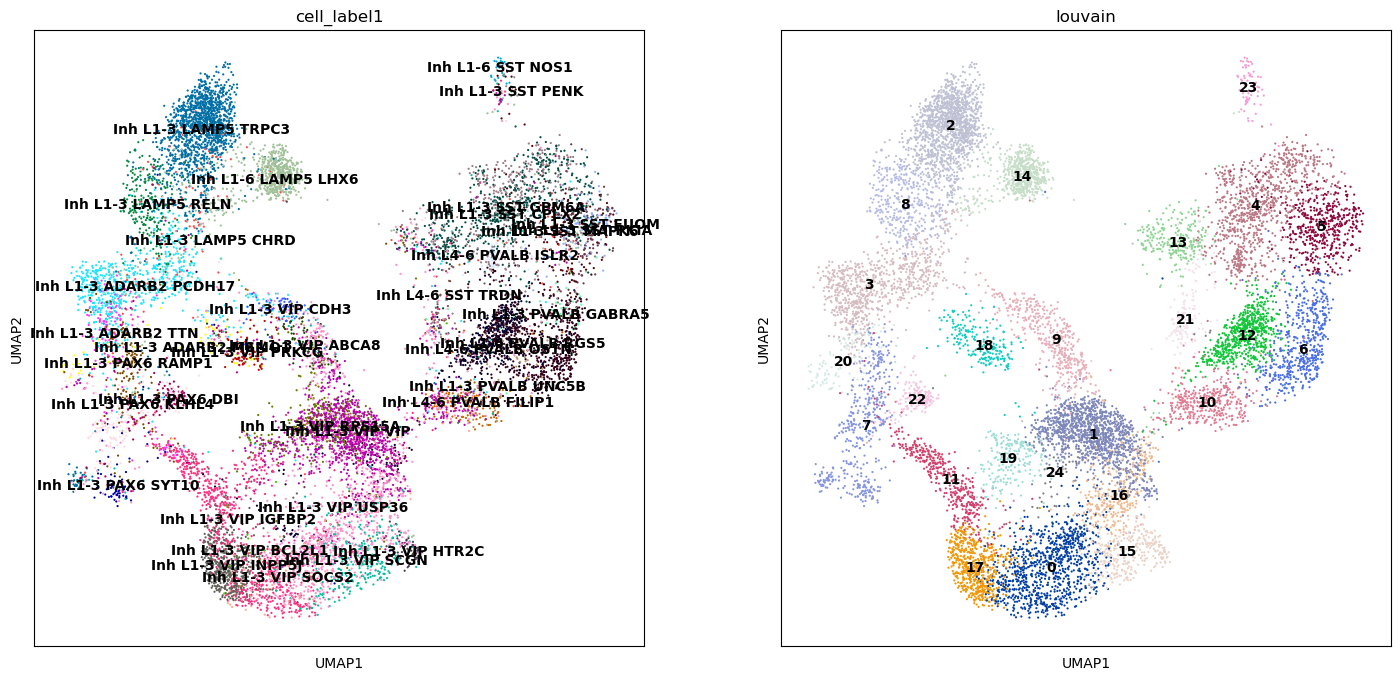

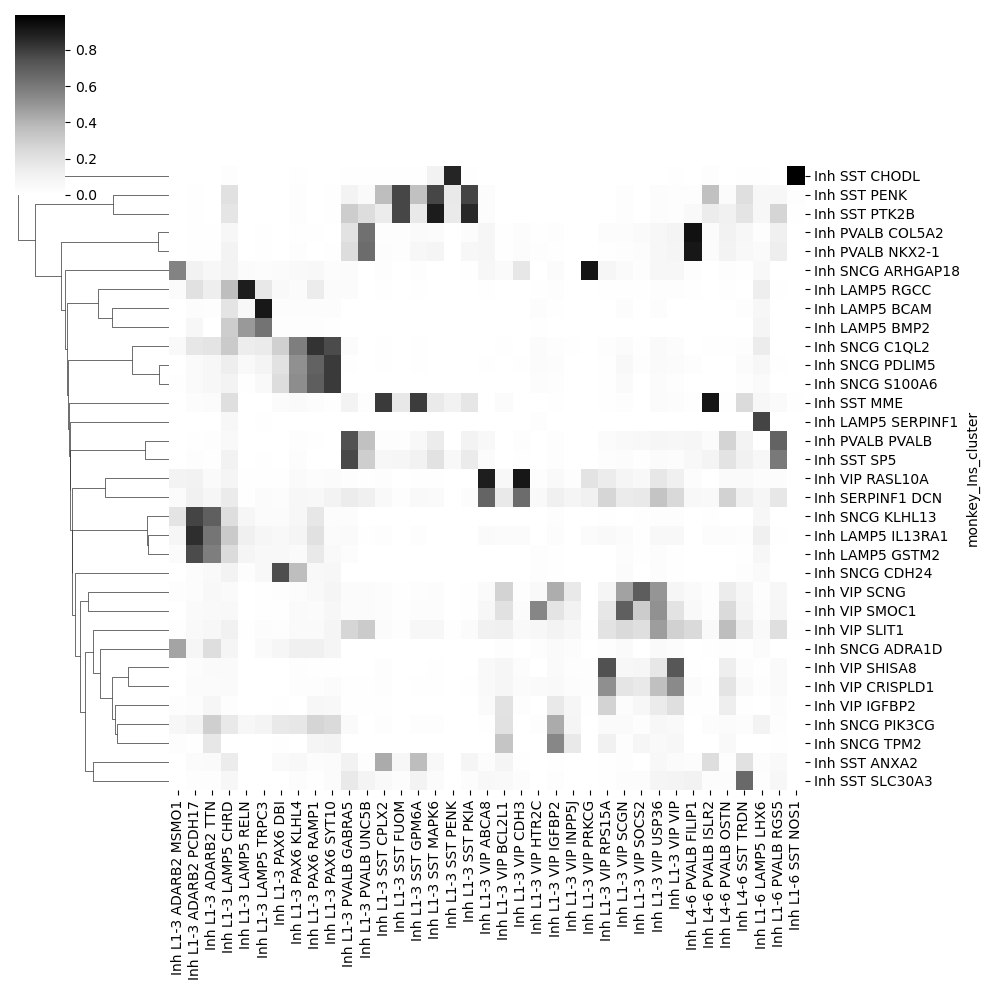

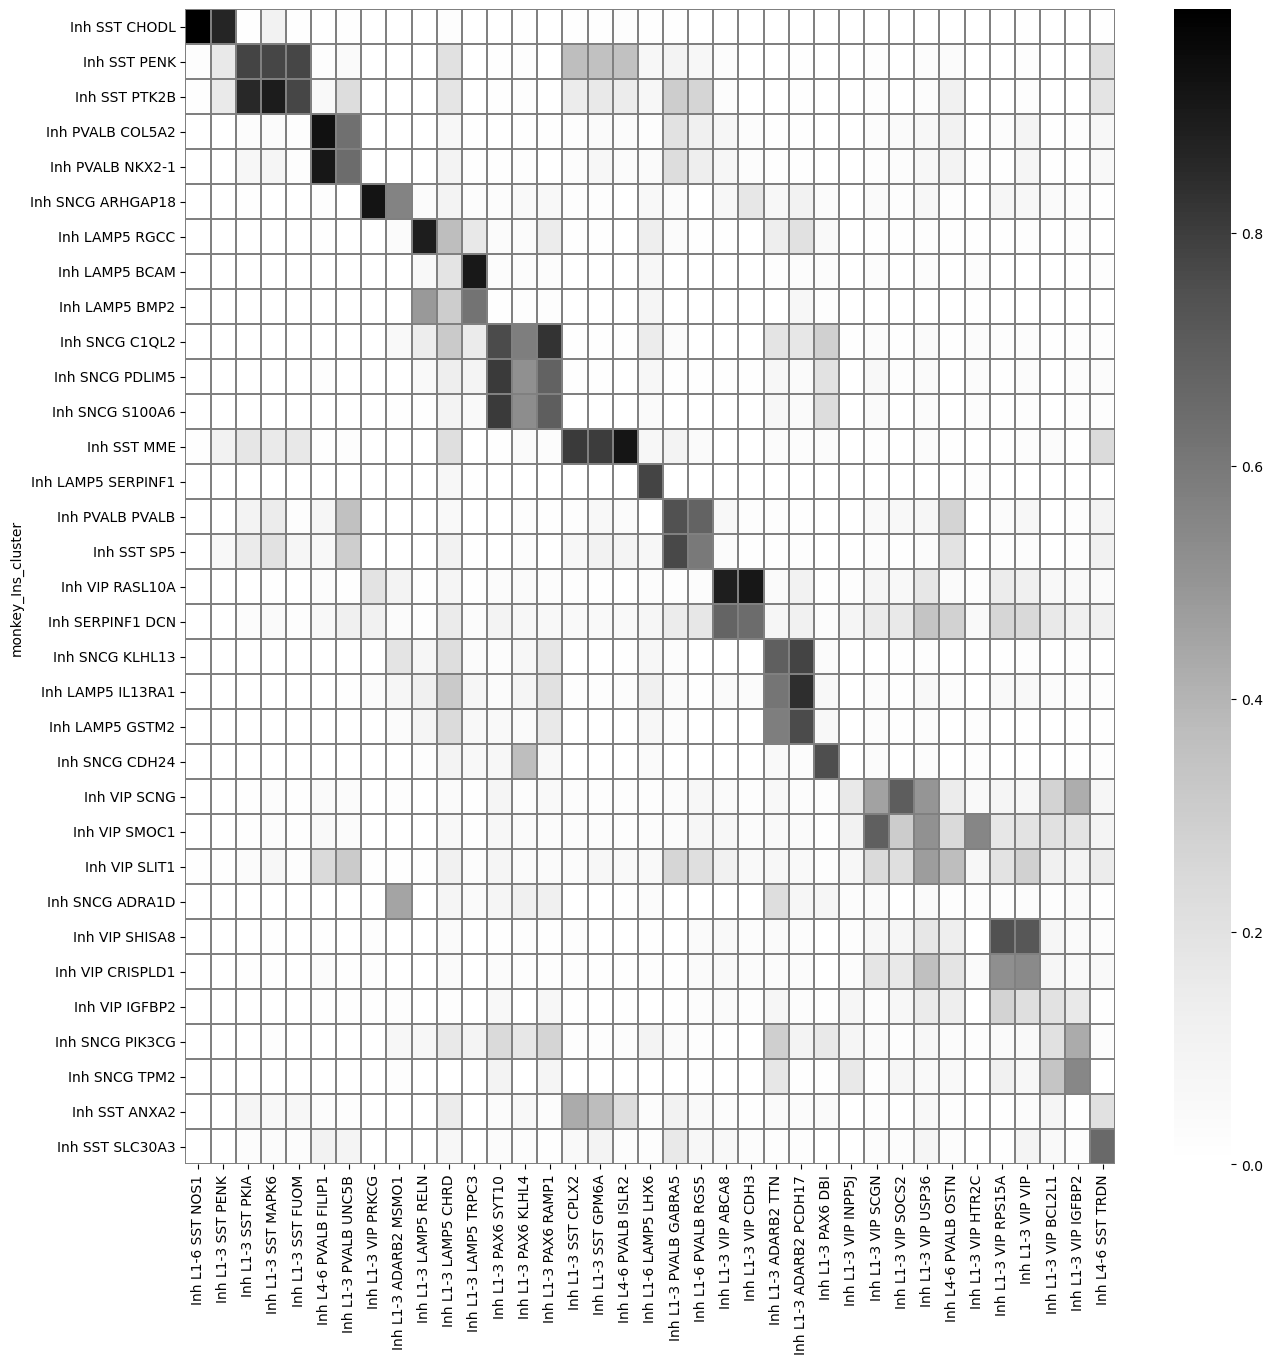

In [25]:
plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6 = two_species_heatmap(adata, species_1 = 'monkey_Ins', species_2 = 'monkey_V1',\
                species_1_key = 'cellTypeLabel', species_2_key = 'cell_label1',\
                louvain = 1.8)#,figure_path = 'neurons_heatmap_cmp.png')

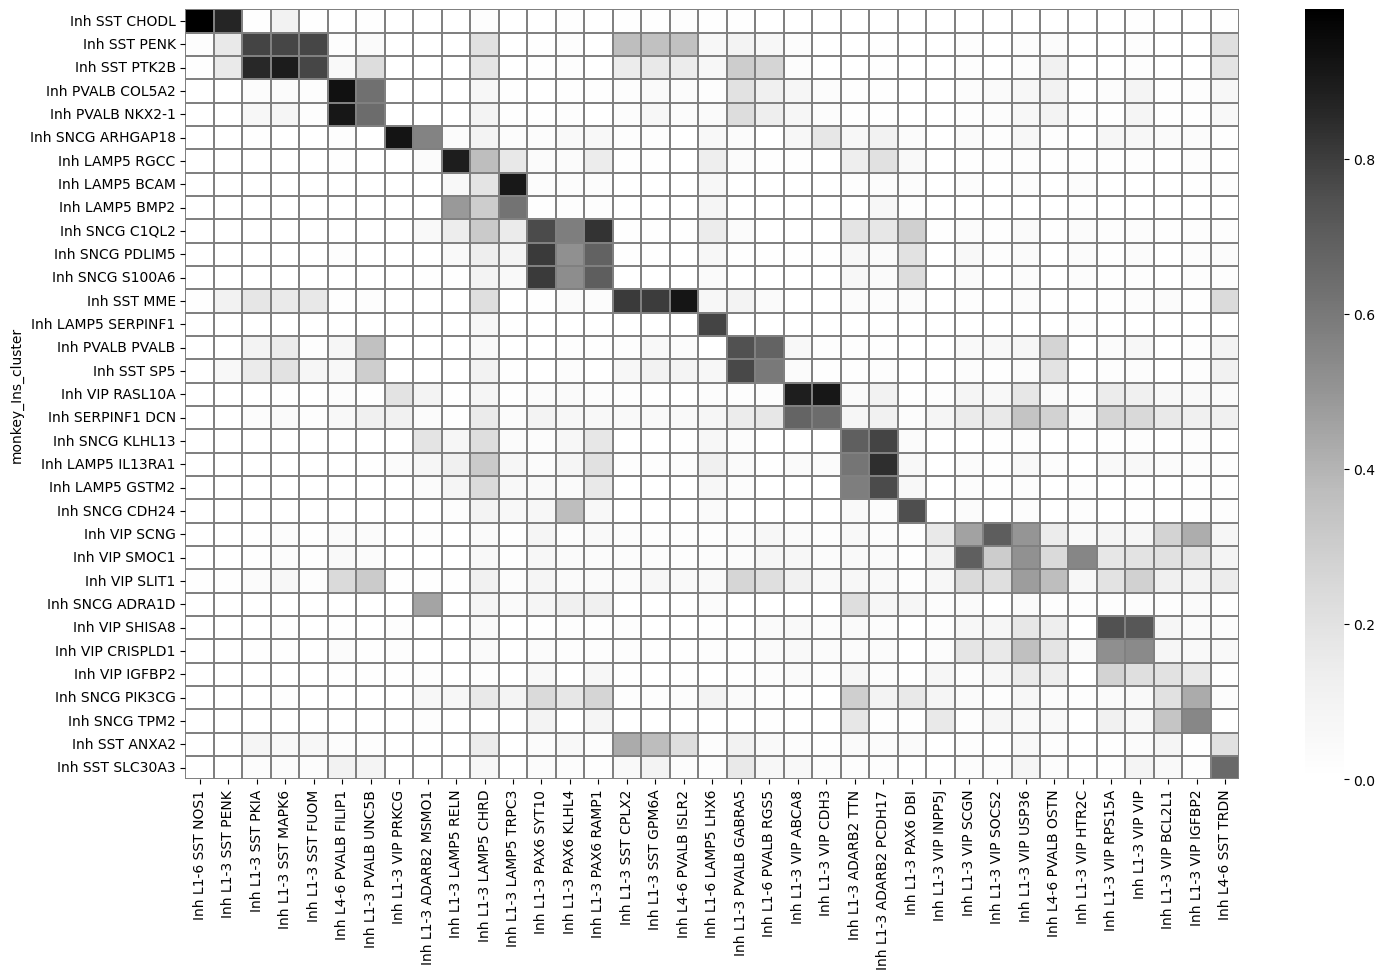

In [26]:
plt.figure(figsize = (17,10))
sns_plot = sns.heatmap(plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 0.01, linecolor = 'gray')

In [27]:
adata.write('./data_tem/integrated_Inh_mk_Ins_vs_V1_final.h5ad',compression='gzip')

In [28]:
plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6.columns

Index(['Inh L1-6 SST NOS1', 'Inh L1-3 SST PENK', 'Inh L1-3 SST PKIA',
       'Inh L1-3 SST MAPK6', 'Inh L1-3 SST FUOM', 'Inh L4-6 PVALB FILIP1',
       'Inh L1-3 PVALB UNC5B', 'Inh L1-3 VIP PRKCG', 'Inh L1-3 ADARB2 MSMO1',
       'Inh L1-3 LAMP5 RELN', 'Inh L1-3 LAMP5 CHRD', 'Inh L1-3 LAMP5 TRPC3',
       'Inh L1-3 PAX6 SYT10', 'Inh L1-3 PAX6 KLHL4', 'Inh L1-3 PAX6 RAMP1',
       'Inh L1-3 SST CPLX2', 'Inh L1-3 SST GPM6A', 'Inh L4-6 PVALB ISLR2',
       'Inh L1-6 LAMP5 LHX6', 'Inh L1-3 PVALB GABRA5', 'Inh L1-6 PVALB RGS5',
       'Inh L1-3 VIP ABCA8', 'Inh L1-3 VIP CDH3', 'Inh L1-3 ADARB2 TTN',
       'Inh L1-3 ADARB2 PCDH17', 'Inh L1-3 PAX6 DBI', 'Inh L1-3 VIP INPP5J',
       'Inh L1-3 VIP SCGN', 'Inh L1-3 VIP SOCS2', 'Inh L1-3 VIP USP36',
       'Inh L4-6 PVALB OSTN', 'Inh L1-3 VIP HTR2C', 'Inh L1-3 VIP RPS15A',
       'Inh L1-3 VIP VIP', 'Inh L1-3 VIP BCL2L1', 'Inh L1-3 VIP IGFBP2',
       'Inh L4-6 SST TRDN'],
      dtype='object')

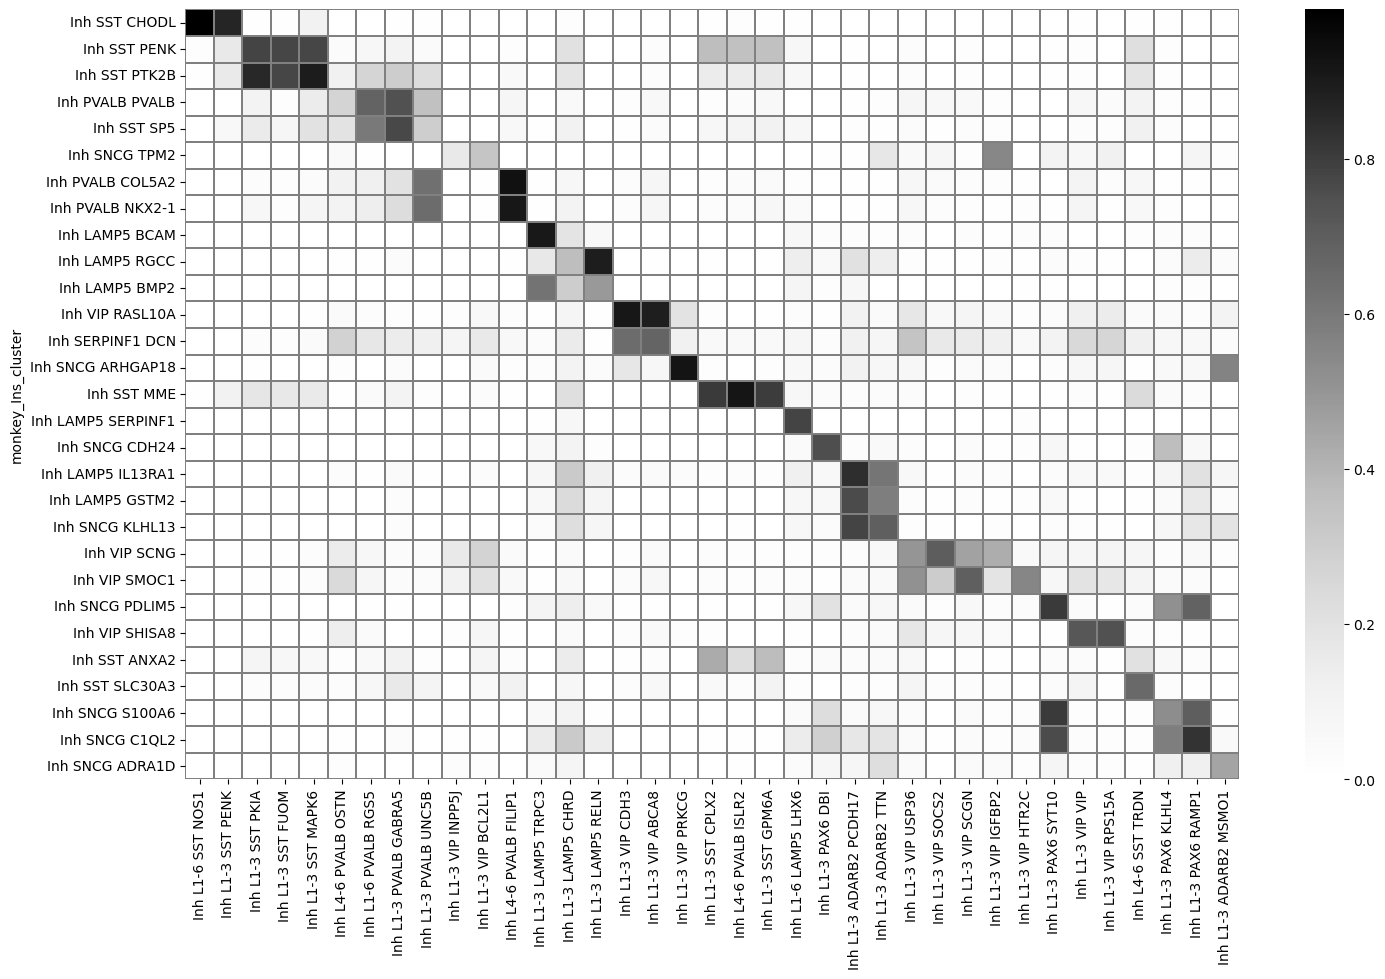

In [29]:
index_order = ['Inh SST CHODL', 'Inh SST PENK', 'Inh SST PTK2B', 'Inh PVALB PVALB',
       'Inh SST SP5', 'Inh SNCG TPM2', 'Inh PVALB COL5A2', 'Inh PVALB NKX2-1',
       'Inh LAMP5 BCAM', 'Inh LAMP5 RGCC', 'Inh LAMP5 BMP2', 'Inh VIP RASL10A',
       'Inh SERPINF1 DCN', 'Inh SNCG ARHGAP18', 'Inh SST MME',
       'Inh LAMP5 SERPINF1', 'Inh SNCG CDH24', 'Inh LAMP5 IL13RA1',
       'Inh LAMP5 GSTM2', 'Inh SNCG KLHL13', 'Inh VIP SCNG', 'Inh VIP SMOC1',
       'Inh SNCG PDLIM5', 'Inh VIP SHISA8', 'Inh SST ANXA2', 'Inh SST SLC30A3',
       'Inh SNCG S100A6', 'Inh SNCG C1QL2', 'Inh SNCG ADRA1D']

column_order = ['Inh L1-6 SST NOS1', 'Inh L1-3 SST PENK', 'Inh L1-3 SST PKIA',
       'Inh L1-3 SST FUOM', 'Inh L1-3 SST MAPK6', 'Inh L4-6 PVALB OSTN',
       'Inh L1-6 PVALB RGS5', 'Inh L1-3 PVALB GABRA5', 'Inh L1-3 PVALB UNC5B',
       'Inh L1-3 VIP INPP5J', 'Inh L1-3 VIP BCL2L1', 'Inh L4-6 PVALB FILIP1',
       'Inh L1-3 LAMP5 TRPC3', 'Inh L1-3 LAMP5 CHRD', 'Inh L1-3 LAMP5 RELN',
       'Inh L1-3 VIP CDH3', 'Inh L1-3 VIP ABCA8', 'Inh L1-3 VIP PRKCG',
       'Inh L1-3 SST CPLX2', 'Inh L4-6 PVALB ISLR2', 'Inh L1-3 SST GPM6A',
       'Inh L1-6 LAMP5 LHX6', 'Inh L1-3 PAX6 DBI', 'Inh L1-3 ADARB2 PCDH17',
       'Inh L1-3 ADARB2 TTN', 'Inh L1-3 VIP USP36', 'Inh L1-3 VIP SOCS2',
       'Inh L1-3 VIP SCGN', 'Inh L1-3 VIP IGFBP2', 'Inh L1-3 VIP HTR2C',
       'Inh L1-3 PAX6 SYT10', 'Inh L1-3 VIP VIP', 'Inh L1-3 VIP RPS15A',
       'Inh L4-6 SST TRDN', 'Inh L1-3 PAX6 KLHL4', 'Inh L1-3 PAX6 RAMP1',
       'Inh L1-3 ADARB2 MSMO1']
plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6 = plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6.reindex(index=index_order,columns=column_order)

plt.figure(figsize = (17,10))
sns_plot = sns.heatmap(plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 0.01, linecolor = 'gray')
# plt.savefig('figs/cmpMatrix_Inh_Ins_vs_V1_500VirableGenes.pdf',dpi = 600, )

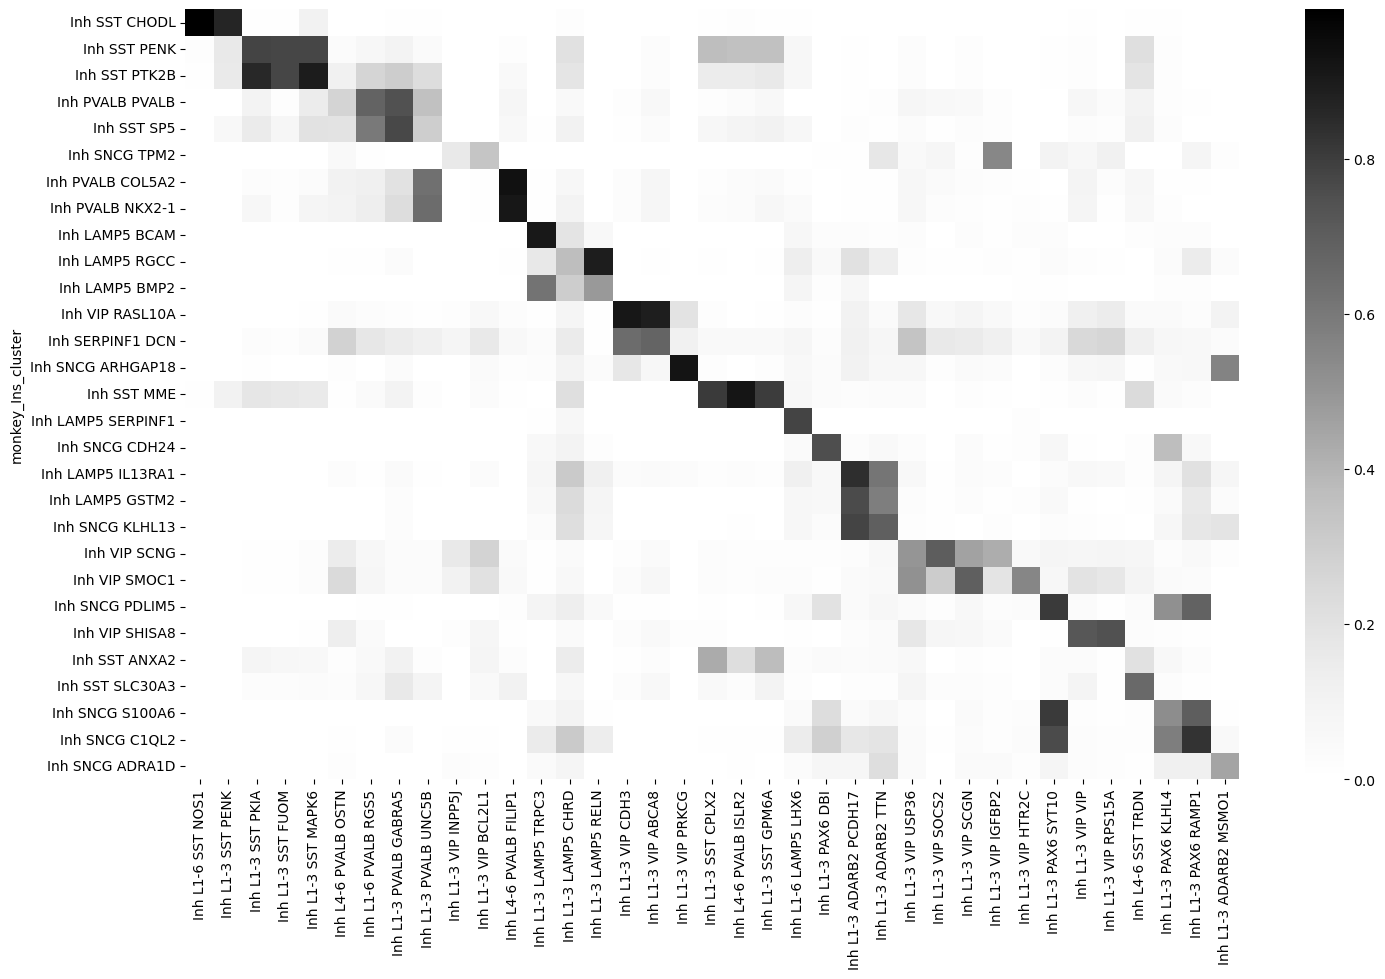

In [30]:
plt.figure(figsize = (17,10))
sns_plot = sns.heatmap(plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 0, linecolor = 'gray')

In [31]:
# set the first level markers groups...
subclass_markers = adata.obs['brainArea'].astype(str)
subclass_markers[adata.obs['louvain'].isin(['3','4','7','15'])] = 'LAMP5'
subclass_markers[adata.obs['louvain'].isin(['1','2','8','9','10','14','16','17','24'])] = 'VIP'
subclass_markers[adata.obs['louvain'].isin(['13','18','19','21','22'])] = 'SNCG'
subclass_markers[adata.obs['louvain'].isin(['12'])] = 'PVALB'
subclass_markers[adata.obs['louvain'].isin(['0','5','6','11','20','23'])] = 'SST'
adata.obs['subclass_markers'] = subclass_markers.astype('category')

# set the first level markers groups...
subclass_markers2 = subclass_markers
subclass_markers2[adata.obs['louvain'].isin(['4','7'])] = 'LAMP5 1'
subclass_markers2[adata.obs['louvain'].isin(['15'])] = 'LAMP5 2'
subclass_markers2[adata.obs['louvain'].isin(['3'])] = 'LAMP5 3'

subclass_markers2[adata.obs['louvain'].isin(['8'])] = 'VIP 1'
subclass_markers2[adata.obs['louvain'].isin(['9','17'])] = 'VIP 2'
subclass_markers2[adata.obs['louvain'].isin(['17'])] = 'VIP 3'
subclass_markers2[adata.obs['louvain'].isin(['1','10','14','24'])] = 'VIP 4'
subclass_markers2[adata.obs['louvain'].isin(['2','16'])] = 'VIP 5'

subclass_markers2[adata.obs['louvain'].isin(['22'])] = 'SNCG 1'
subclass_markers2[adata.obs['louvain'].isin(['19'])] = 'SNCG 2'
subclass_markers2[adata.obs['louvain'].isin(['13'])] = 'SNCG 3'
subclass_markers2[adata.obs['louvain'].isin(['4'])] = 'SNCG 4'

subclass_markers2[adata.obs['louvain'].isin(['0'])] = 'PVALB 1'
subclass_markers2[adata.obs['louvain'].isin(['12'])] = 'PVALB 2'

subclass_markers2[adata.obs['louvain'].isin(['23'])] = 'SST 1'
subclass_markers2[adata.obs['louvain'].isin(['6'])] = 'SST 2'
subclass_markers2[adata.obs['louvain'].isin(['5','11'])] = 'SST 3'
subclass_markers2[adata.obs['louvain'].isin(['20'])] = 'SST 4'
adata.obs['subclass_markers2'] = subclass_markers2.astype('category')

adata.uns['subclass_markers2_colors'] = np.array([ '#DDACC9', '#DEB887', '#DD8091', '#7C086C', '#FFD700', '#FF8C97',
                              '#FFA388', '#C77963', '#7E0ACB', '#FF4500', '#FF0000', '#9900B3',
                              '#C9AE9C', '#AA4DB5',  '#AB1DFF', '#FF5FCD', '#FFC0CB',
                               '#B09FFF', '#DAA520', '#992E81', '#F70CF3', '#FFBF09', '#AB379C','#FF1493',])

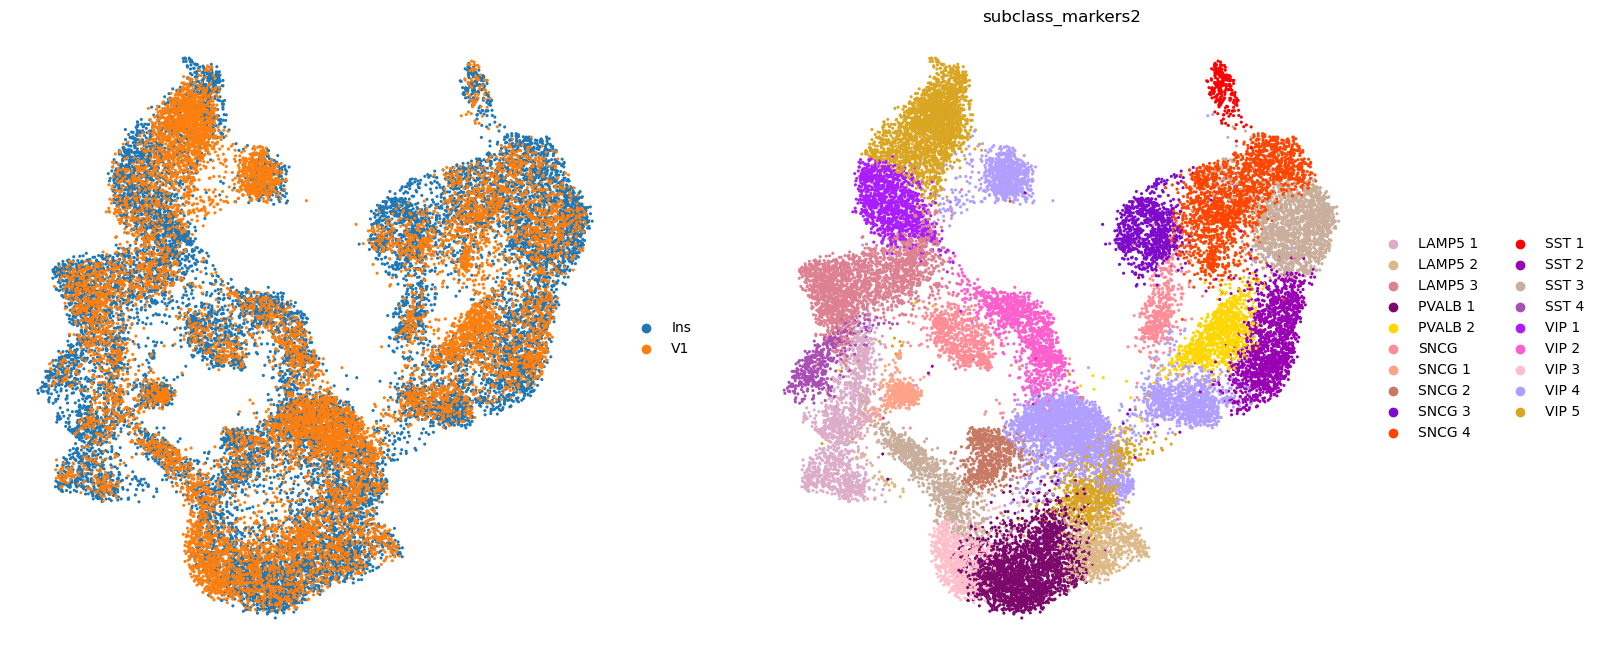

In [32]:
# plot the umaps
figsize(8,8)
sc.pl.umap(adata,color=['brainArea','subclass_markers2'],legend_loc='right margin',size=20,frameon='',title='',save='V1_vs_Ins.pdf')

In [33]:
adata

AnnData object with n_obs × n_vars = 28461 × 500
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellTypeLabel', 'Sex', 'pct_counts_mt', 'batch_ori', 'cell_label1', 'subclass_1', 'subclass_2', 'n_genes_by_counts', 'total_counts', 'n_counts', 'louvain', 'louvain0_6', 'subclass_markers', 'subclass_markers2'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'brainArea_colors', 'batch_ori_colors', 'louvain', 'species_colors', 'louvain_colors', 'subclass_markers2_colors'
    obsm: 'X_pca', 'X_umap', 'X_harmonypca', 'X_umapraw', 'X_umapharmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

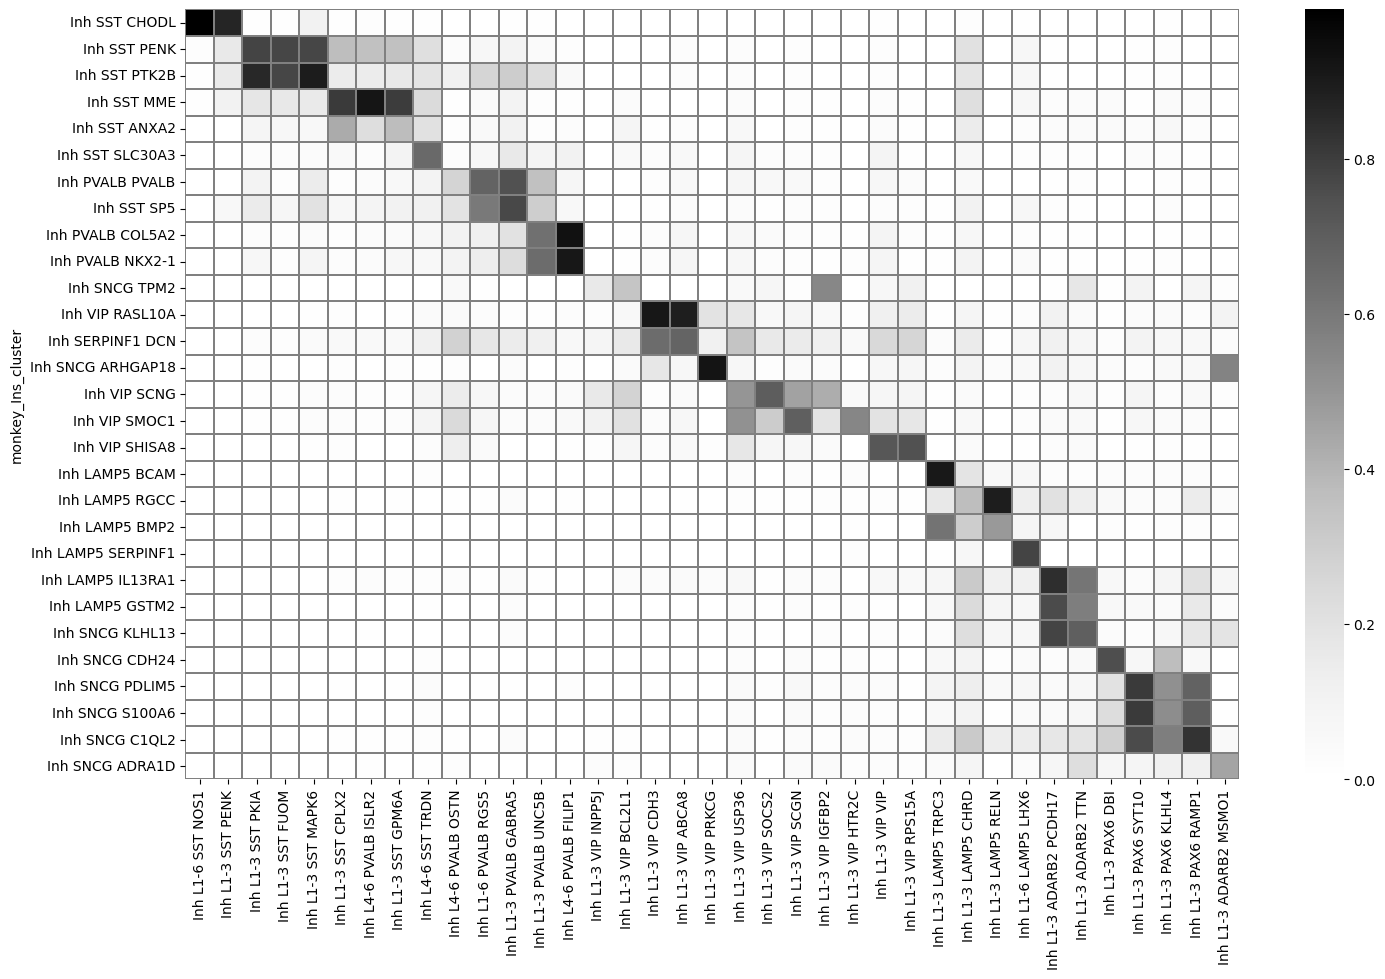

In [35]:
index_order = ['Inh SST CHODL', 
               'Inh SST PENK', 'Inh SST PTK2B', 
               'Inh SST MME',  
               'Inh SST ANXA2', 'Inh SST SLC30A3',   # SST              
               
               'Inh PVALB PVALB','Inh SST SP5',                       # PVALB
               'Inh PVALB COL5A2', 'Inh PVALB NKX2-1',                # PVALB
               
               'Inh SNCG TPM2',                                       # VIP
               'Inh VIP RASL10A', 'Inh SERPINF1 DCN',                  # VIP
               'Inh SNCG ARHGAP18',                                 # VIP
               'Inh VIP SCNG', 'Inh VIP SMOC1',                     # VIP
               'Inh VIP SHISA8',                                    # VIP 
               
               
               'Inh LAMP5 BCAM', 'Inh LAMP5 RGCC', 'Inh LAMP5 BMP2',    # LAMP5
               'Inh LAMP5 SERPINF1',                                     # LAMP5
               'Inh LAMP5 IL13RA1', 'Inh LAMP5 GSTM2', 'Inh SNCG KLHL13', 
               
               'Inh SNCG CDH24',                # SNCG
               'Inh SNCG PDLIM5',        
               'Inh SNCG S100A6', 'Inh SNCG C1QL2', 
               'Inh SNCG ADRA1D']

column_order = ['Inh L1-6 SST NOS1', 'Inh L1-3 SST PENK',               # SST     
                'Inh L1-3 SST PKIA',  'Inh L1-3 SST FUOM', 'Inh L1-3 SST MAPK6',    #SST
                'Inh L1-3 SST CPLX2', 'Inh L4-6 PVALB ISLR2', 'Inh L1-3 SST GPM6A',  # SST     
                'Inh L4-6 SST TRDN', # SST     
                
                'Inh L4-6 PVALB OSTN', 'Inh L1-6 PVALB RGS5', 'Inh L1-3 PVALB GABRA5', 'Inh L1-3 PVALB UNC5B', 'Inh L4-6 PVALB FILIP1',
        
                'Inh L1-3 VIP INPP5J', 'Inh L1-3 VIP BCL2L1',                         # VIP
                'Inh L1-3 VIP CDH3', 'Inh L1-3 VIP ABCA8',                              # VIP
                'Inh L1-3 VIP PRKCG',                                                  # VIP
                'Inh L1-3 VIP USP36', 'Inh L1-3 VIP SOCS2', 'Inh L1-3 VIP SCGN', 'Inh L1-3 VIP IGFBP2', 'Inh L1-3 VIP HTR2C',    # VIP
                'Inh L1-3 VIP VIP', 'Inh L1-3 VIP RPS15A',                              # VIP
                
                'Inh L1-3 LAMP5 TRPC3', 'Inh L1-3 LAMP5 CHRD', 'Inh L1-3 LAMP5 RELN',      # LAMP5
                'Inh L1-6 LAMP5 LHX6',                                         # LAMP5
                'Inh L1-3 ADARB2 PCDH17', 'Inh L1-3 ADARB2 TTN',              # LAMP5
       
                'Inh L1-3 PAX6 DBI',                  # SNCG
                'Inh L1-3 PAX6 SYT10',        
                'Inh L1-3 PAX6 KLHL4', 'Inh L1-3 PAX6 RAMP1',
                'Inh L1-3 ADARB2 MSMO1']
plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6 = plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6.reindex(index=index_order,columns=column_order)

plt.figure(figsize = (17,10))
sns_plot = sns.heatmap(plot_NeuronMatrix_ins_vs_HodgeMus_lovain_0_6, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 0.01, linecolor = 'gray')
plt.savefig('figures/cmpMatrix_Inh_Ins_vs_V1_500VirableGenes.pdf',dpi = 600, )

In [36]:
adata.write('./data_tem/integrated_Inh_mk_Ins_vs_V1_final.h5ad',compression='gzip')